# Test Recurrent Policy with Extreme Parameter Variation 

In [3]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../RL_lib/Models')
sys.path.append('../../../Asteroid3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_Meta-Learning-master/Experiments/Asteroid_3DOF/Asteroid_PV_sphere


In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
Glideslope Constraint: delta =  3
Flat Constraint


<IPython.core.display.Javascript object>


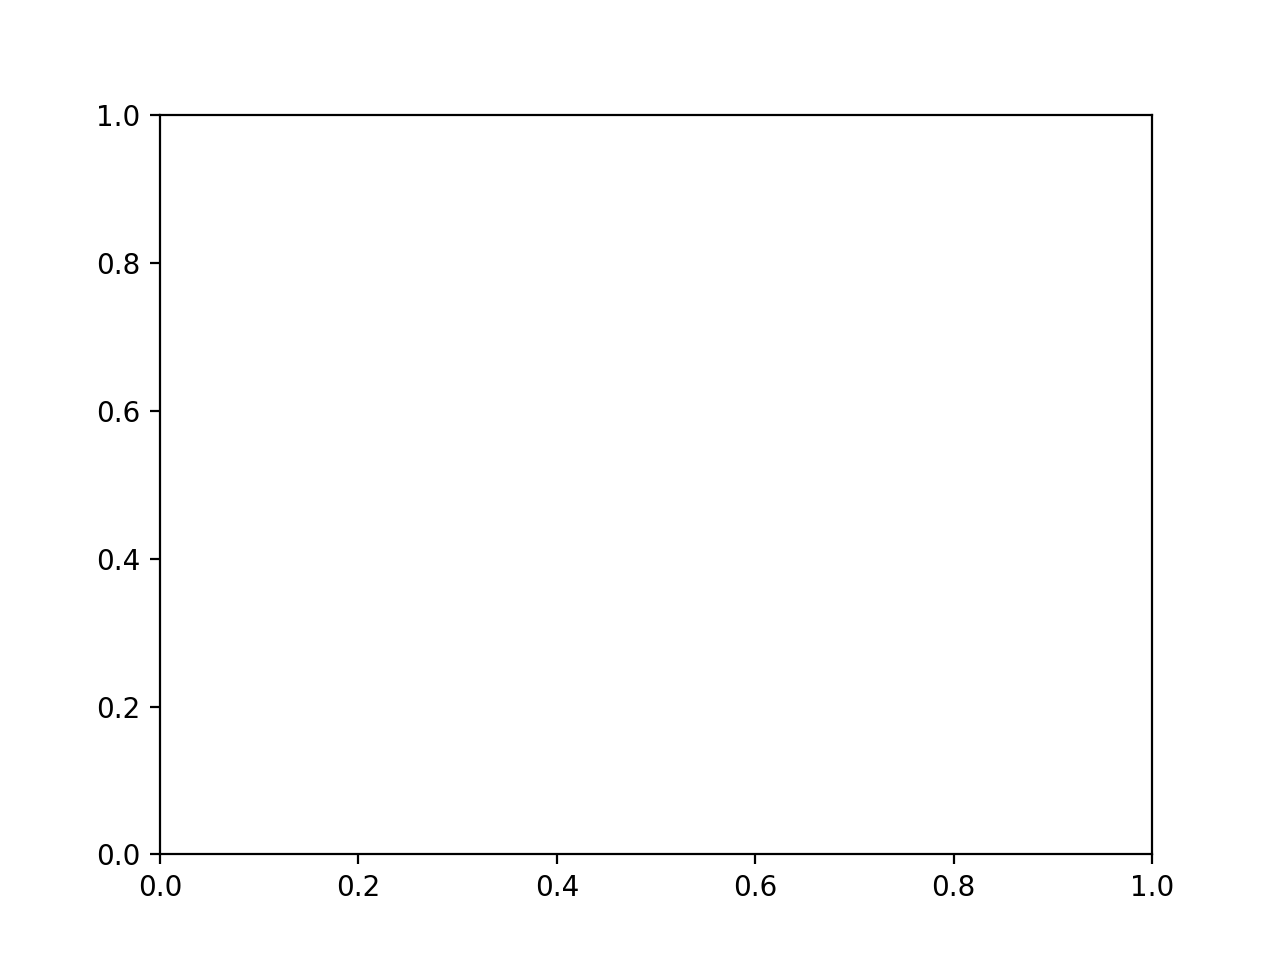

<IPython.core.display.Javascript object>


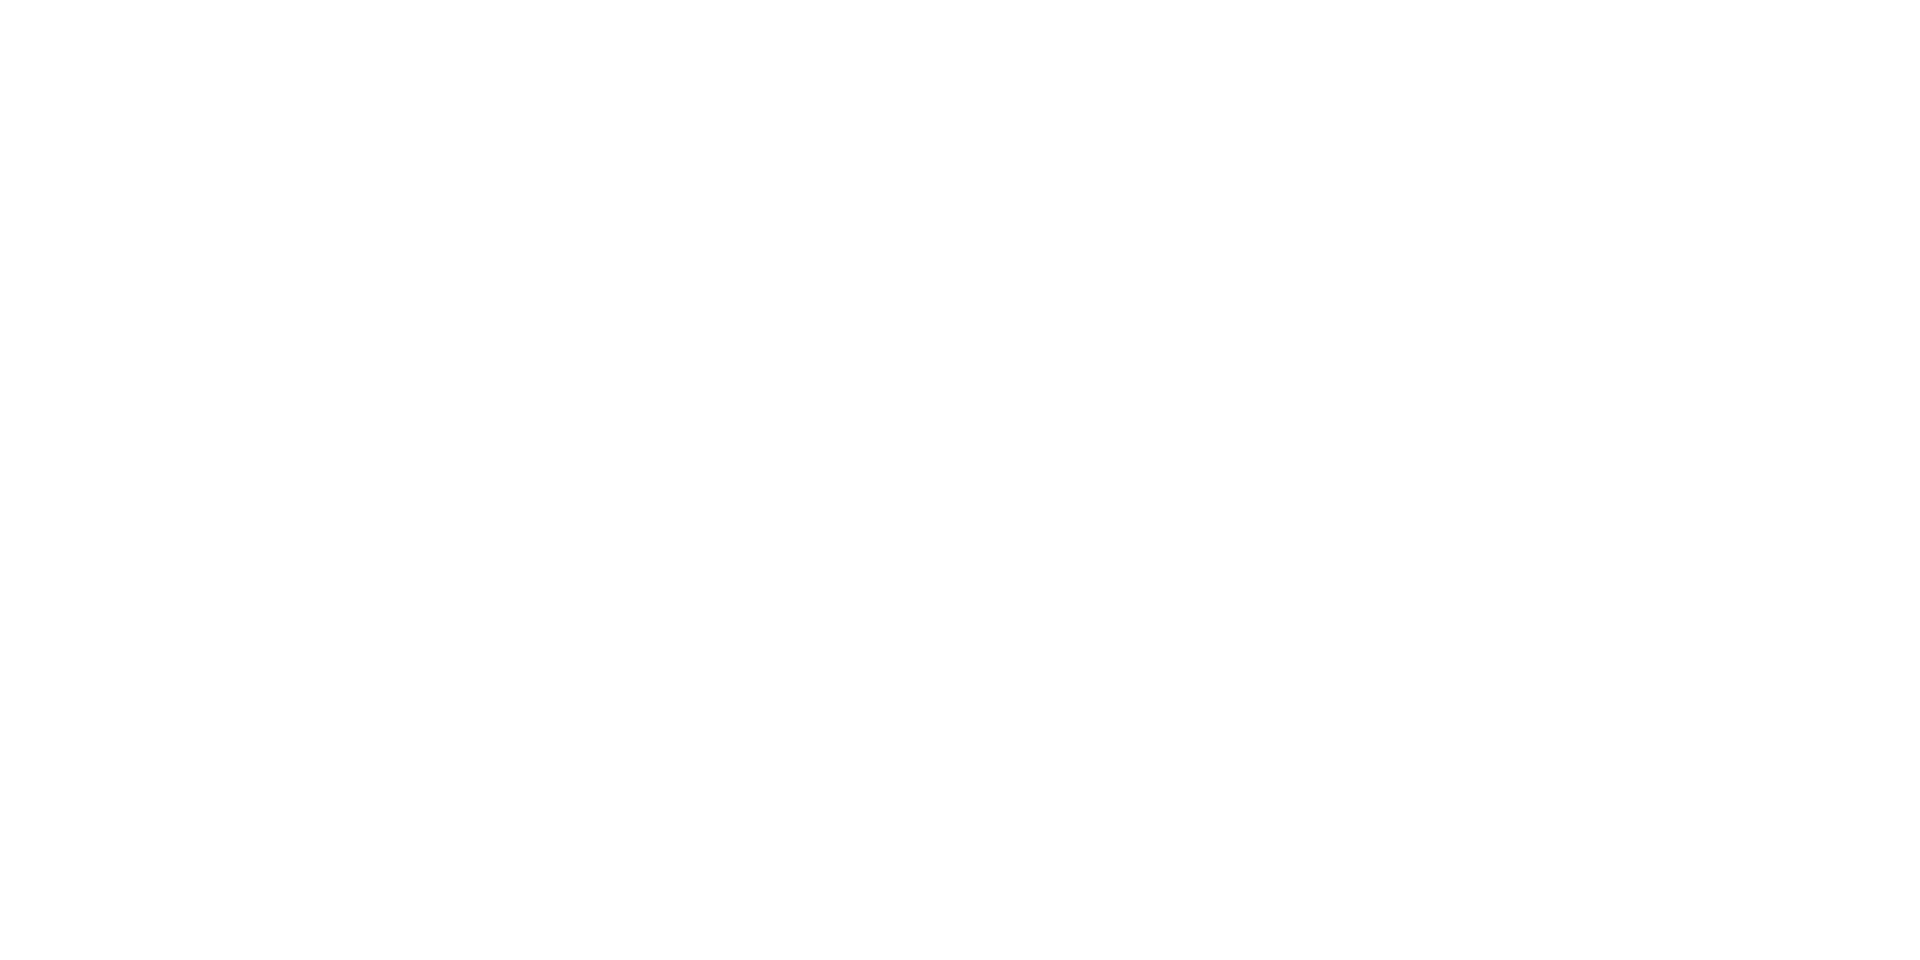

<IPython.core.display.Javascript object>


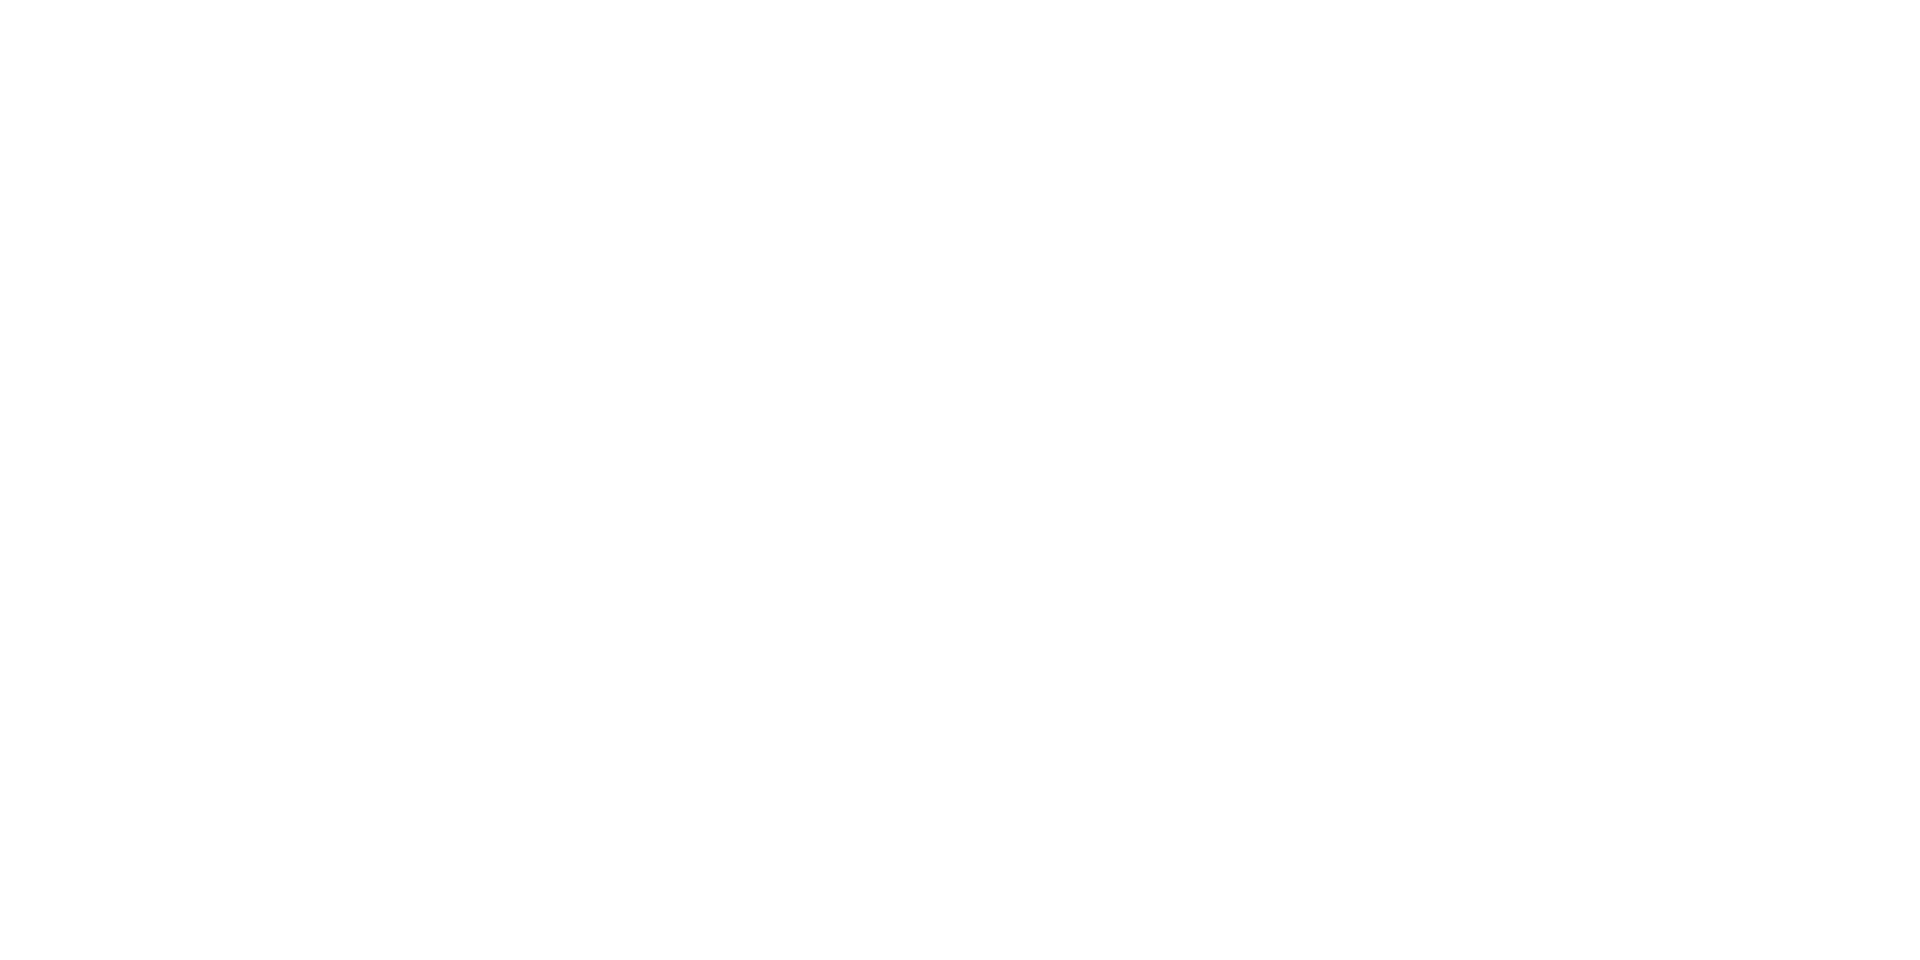

<IPython.core.display.Javascript object>


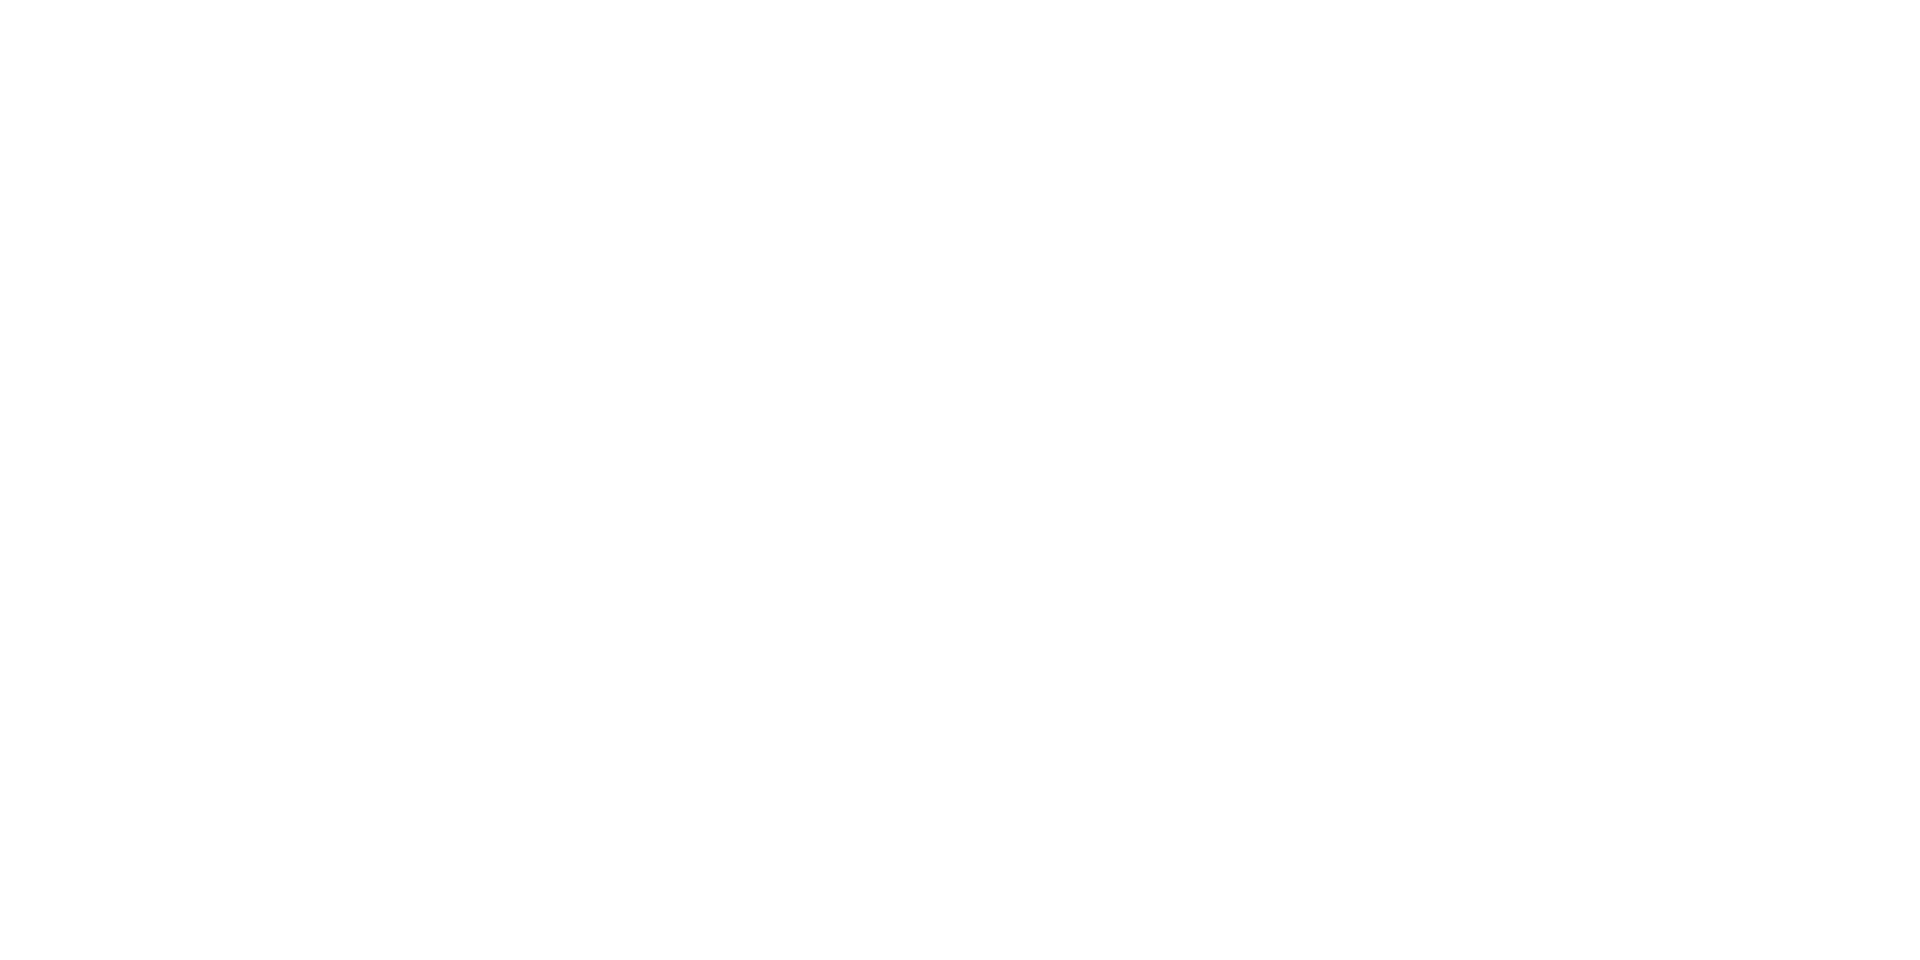

<IPython.core.display.Javascript object>


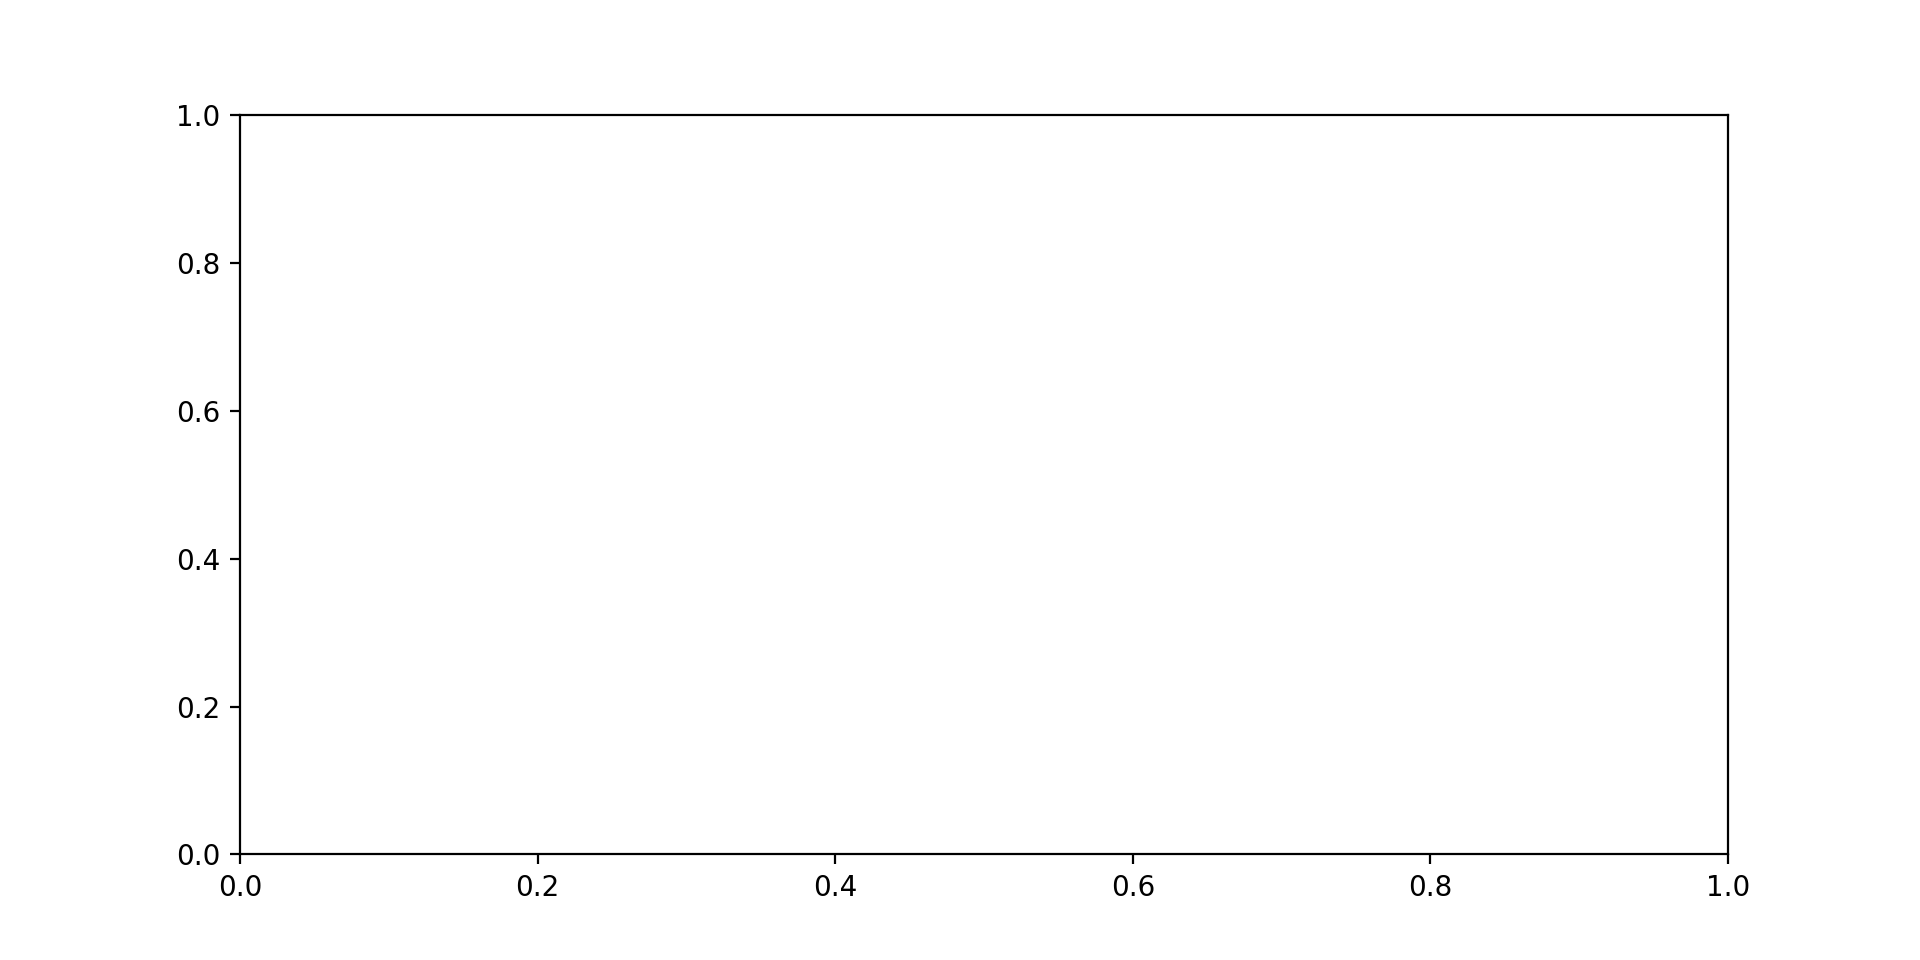

Lander Env
Landing_icgen:
    adjust_apf_v0               :  False
    w (min/max)                 :  (-0.0011, -0.0011, -0.0011) (0.0011, 0.0011, 0.0011)
 mass (min/max)                 :  450 500
  srp (min/max)                 :  (-1e-06, -1e-06, -1e-06) (1e-06, 1e-06, 1e-06)
M (min/max)                     :  (20000000000.0, 200000000000.0)
Position Theta                  :  (0, 0.7853981633974483)
Position Phi                    :  (-3.141592653589793, 3.141592653589793)
Policy with vectorized sample
	xn_init: layer  Linear(in_features=4, out_features=40, bias=True)
	xn_init: layer  Linear(in_features=40, out_features=34, bias=True)
	xn_init: layer  Linear(in_features=34, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           True
	Max Grad Norm:      30
	Recurrent Steps:    1
	Rollout Limit:      1
Value Funtion
	xn_init: layer  Linear(in_features

In [5]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen_sphere import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from model import Model
from policy import Policy
from value_function import Value_function

import pcm_model_nets as model_nets
import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model(landing_target=np.asarray([0., 0., 250.]))
lander_model = Lander_model(apf_tau1=300, apf_tau2=300, apf_vf1=-0.2, apf_vf2=-0.01, apf_atarg=20, apf_v0=1.0,
                           sensor_bias_range=(-0.0,0.0))
lander_model.min_thrust = 0
lander_model.max_thrust = 2
lander_model.get_state_agent = lander_model.get_state_agent2
lander_model.apf_pot = lander_model.apf_pot2
obs_dim = 4
act_dim = 3
recurrent_steps = 1

reward_object = Reward(landing_coeff=10.0, landing_rlimit=1, landing_vlimit=0.2, 
                       tracking_coeff=-1.00, fuel_coeff=-0.01, landing_gslimit=-1)

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=5000.0,print_every=10,
           nav_period=6)


min_w   = -1.1e-3
max_w   =  1.1e-3


env.ic_gen = Landing_icgen(adjust_apf_v0=False,
                            position_theta=(0,np.pi/4),
                            min_mass = 450, max_mass=500,
                            min_w=(min_w,min_w,min_w),  max_w=(max_w,max_w,max_w))

                            
                          
                           
env.ic_gen.show()

arch = Arch()

policy = Policy(policy_nets.MLP1(obs_dim, act_dim), shuffle=True,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init, discretize=True)
value_function = Value_function(valfunc_nets.MLP1(obs_dim), 
                                shuffle=True, batch_size=256, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)

fname = "MLP-sphere"
policy.load_params(fname)
value_function.load_params(fname)

# Test Policy 

In [6]:
print(1)
policy.test_mode=True  
env.test_policy_batch(agent,10000,print_every=100)

1
Dynamics: Max Disturbance (m/s^2):  [0.00014684 0.00027081 0.00032896] 0.00045068342265366246
Dynamics: Max w:                    [ 0.00033768  0.00049006 -0.00056571]
Dynamics: Max Disturbance (m/s^2):  [0.00297077 0.00266948 0.00311096] 0.0050625747436169695
Dynamics: Max w:                    [-0.00105484  0.00097612  0.00050197]
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.32 |  1.19 |  0.00 |  3.46 |     1
glideslope | 7.955 |25.668 | 0.256 |2493.979 |    73
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.022 |   0.007 |   0.007 |   0.041
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.1    -0.1    -0.0 |     0.1     0.1    -0.0
velocity |  -0.002  -0.001  -0.016 |   0.012   0.011   0.007 |  -0.032  -0.038  -0.032 |   0.026   0.025  -0.001
fuel     |  1.03 |  0.18 |  0.66 |  1.77
glideslope |  4.13 |  4.68 |  0.88 | 26.60
Dynamics: Max Distur

Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  1100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.880 |24.628 | 0.125 |3464.941 |   737
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.044
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.0     0.1     0.0 |    -0.1    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.001  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.032 |   0.028   0.032  -0.000
fuel     |  1.05 |  0.21 |  0.63 |  2.42
glideslope |  5.18 |  8.11 |  0.84 |103.98
Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  1200
Cumulative Stats (mean

Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  2100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.35 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.806 |25.130 | 0.105 |3464.941 |   737
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.047
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.1    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.032 |   0.032   0.034  -0.000
fuel     |  1.05 |  0.21 |  0.61 |  2.42
glideslope |  5.22 | 13.03 |  0.84 |436.95
Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  2200
Cumulative Stats (mean

Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  3100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.846 |25.670 | 0.105 |6637.349 |  2583
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.047
norm_rf  |     0.1 |     0.0 |     0.0 |     0.2
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.035 |   0.032   0.034  -0.000
fuel     |  1.05 |  0.21 |  0.58 |  2.42
glideslope |  5.26 | 12.22 |  0.84 |436.95
Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00367871 0.00420305] 0.00652123263339529
Dynamics: Max w:                    [0.00107973 0.00103744 0.00054363]
i :  3200
Cumulative Stats (mean

i :  4100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.794 |25.281 | 0.105 |6637.349 |  2583
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.003 |   0.047
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.035 |   0.032   0.037   0.001
fuel     |  1.05 |  0.21 |  0.58 |  2.42
glideslope |  5.38 | 13.36 |  0.84 |436.95
Dynamics: Max Disturbance (m/s^2):  [0.0033657  0.00389212 0.00420305] 0.006643953201008335
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  4200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.797 |25.179 | 0.105 |6637.349 |  2583
sc_margin |100.000 | 0.000 |100.000 |10

i :  5100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.35 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.899 |25.949 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.049
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.035 |   0.032   0.037   0.001
fuel     |  1.05 |  0.21 |  0.58 |  2.42
glideslope |  5.43 | 12.72 |  0.84 |436.95
Dynamics: Max Disturbance (m/s^2):  [0.00338105 0.00389212 0.00420305] 0.006651742817403355
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  5200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.35 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.874 |25.852 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |10

i :  6100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.881 |25.624 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.050
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.035 |   0.034   0.037   0.001
fuel     |  1.05 |  0.21 |  0.58 |  2.42
glideslope |  5.53 | 14.28 |  0.84 |521.48
Dynamics: Max Disturbance (m/s^2):  [0.00338462 0.00389212 0.00420305] 0.006653558104797799
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  6200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.876 |25.593 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |10

i :  7100
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.874 |25.447 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.036 |   0.039   0.037   0.001
fuel     |  1.05 |  0.21 |  0.58 |  2.42
glideslope |  5.44 | 13.48 |  0.84 |521.48
Dynamics: Max Disturbance (m/s^2):  [0.00351483 0.00389212 0.00420305] 0.006720726842542525
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  7200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.879 |25.511 | 0.096 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |10

norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.036 |   0.039   0.037   0.001
fuel     |  1.05 |  0.21 |  0.57 |  2.42
glideslope |  5.36 | 12.79 |  0.84 |521.48
Dynamics: Max Disturbance (m/s^2):  [0.00351483 0.00389212 0.00424052] 0.006744227895687277
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  8200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.904 |25.589 | 0.073 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |    

norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |     0.2     0.2    -0.0
velocity |  -0.002  -0.000  -0.015 |   0.010   0.010   0.007 |  -0.039  -0.038  -0.036 |   0.039   0.037   0.001
fuel     |  1.05 |  0.21 |  0.57 |  2.42
glideslope |  5.38 | 12.52 |  0.84 |521.48
Dynamics: Max Disturbance (m/s^2):  [0.00351483 0.00389212 0.00424052] 0.006744227895687277
Dynamics: Max w:                    [-0.00108953 -0.00088433  0.00103038]
i :  9200
Cumulative Stats (mean,std,max,argmax)
thrust   |  1.34 |  1.19 |  0.00 |  3.46 |     1
glideslope | 8.927 |25.515 | 0.073 |6873.314 |  5093
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.021 |   0.007 |   0.002 |   0.051
norm_rf  |     0.1 |     0.0 |     0.0 |     0.3
position |     0.0     0.0    -0.0 |     0.1     0.1     0.0 |    -0.2    -0.2    -0.0 |    

In [8]:
print(1)
policy.test_mode=True  
env.ic_gen.min_w=(-1e-3,-1e-3,1e-3)
env.ic_gen.min_w=(-0.0009,-0.0009,0.001)
env.ic_gen.min_w=(-1.1e-3,-1.1e-3,1.1e-3)
#env.ic_gen.min_w=(-1.1e-6,-1.1e-6,1.1e-6)
v1 = -0.05
v2 = -0.05
v3 = 0.05
env.ic_gen.velocity_x=(v1,v1)
env.ic_gen.velocity_y=(v2,v2)
env.ic_gen.velocity_z=(v3,v3)
env.ic_gen.M = (20e10,20e10)
env.ic_gen.max_w = env.ic_gen.min_w
env.test_policy_batch(agent,1,print_every=1)
print(np.linalg.norm(dynamics_model.max_disturbance))

1

Cumulative Stats (mean,std,max,argmax)
thrust   |  1.95 |  1.12 |  0.00 |  3.46 |     0
glideslope |14.396 |23.205 | 0.579 |100.000 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.013 |   0.000 |   0.013 |   0.013
norm_rf  |     0.1 |     0.0 |     0.1 |     0.1
position |    -0.1     0.0    -0.0 |     0.0     0.0     0.0 |    -0.1     0.0    -0.0 |    -0.1     0.0    -0.0
velocity |   0.001  -0.002  -0.013 |   0.000   0.000   0.000 |   0.001  -0.002  -0.013 |   0.001  -0.002  -0.013
fuel     |  1.77 |  0.00 |  1.77 |  1.77
glideslope |  5.09 |  0.00 |  5.09 |  5.09

Initial Stats (mean,std,min,max)
norm_vf  |   0.087 |   0.000 |   0.087 |   0.087
norm_rf  |   962.2 |     0.0 |   962.2 |   962.2
position |    11.5    89.8   958.0 |     0.0     0.0     0.0 |    11.5    89.8   958.0 |    11.5    89.8   958.0
velocity |  -0.050  -0.050   0.050 |   0.000   0.000   0.000 |  -0.050  -0.050   0.050 |  -0.050  -0.050   0.050
fuel  

<IPython.core.display.Javascript object>


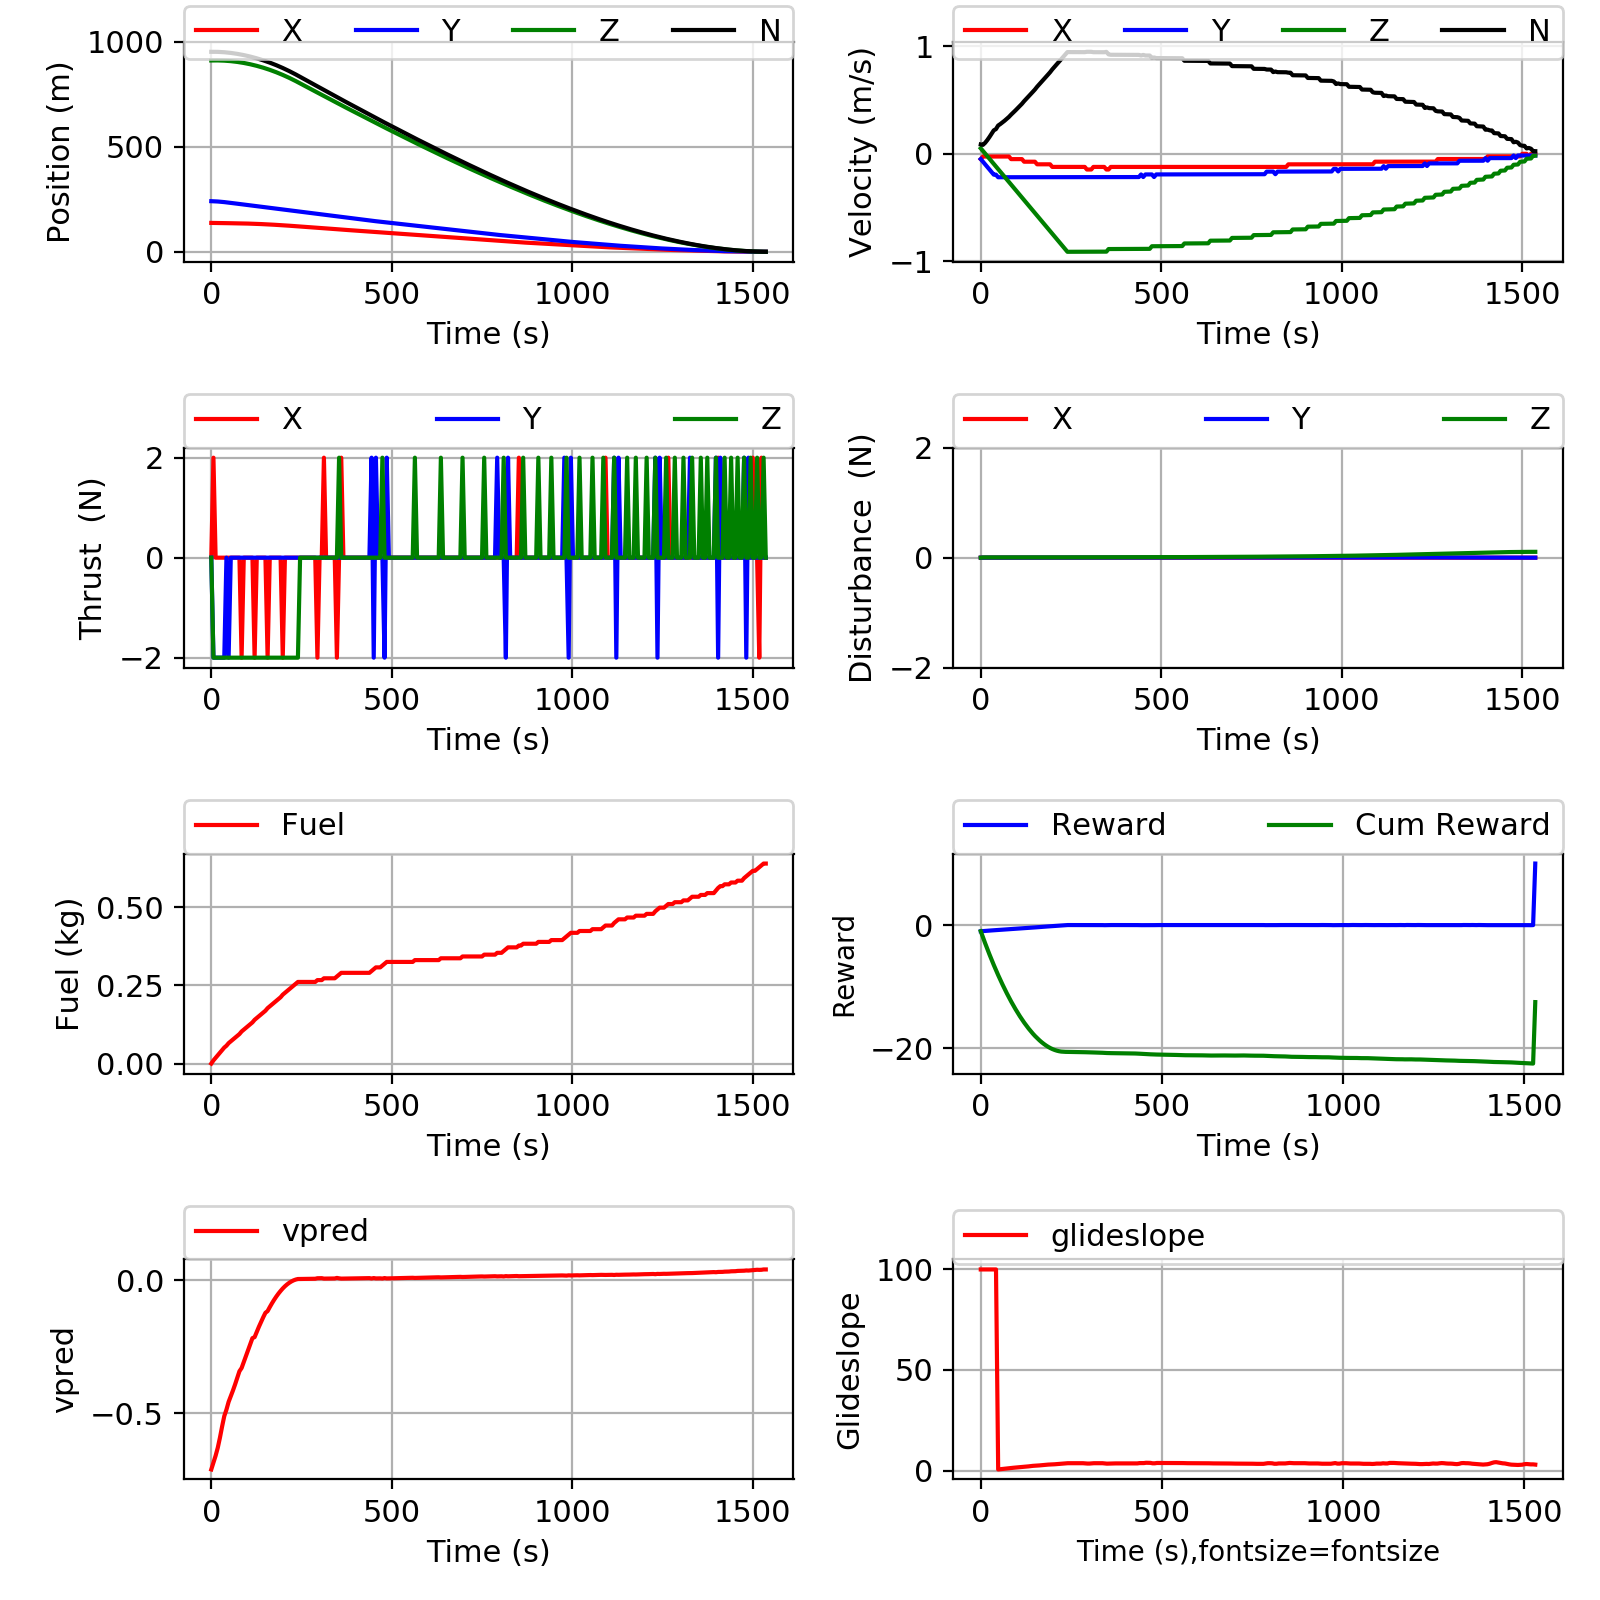

In [7]:
envu.render_traj(lander_model.trajectory_list[0],fontsize=11)